In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx

import plotly.express as px
import plotly

from utils.portfolios import MarkovPortfolio, TobinPortfolio, SharpPortfolio, TreynorPortfolio, JensenPortfolio

from utils.utils import *

import matplotlib.dates as mdates
import seaborn as sns

import pandas_datareader.data as web   

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ret_det_for_all = 0.04
risk_det_for_all = 0.09
market = 'rus' # cab be rus or usa (str)

if market == 'usa':
    index_name = '^GSPC' # ticker of SP500
else:
    index_name = 'IMOEX'

# Data loading

In [3]:
df_all = pd.read_csv(f'data/data_all_{market}.csv', index_col=0)
df_all.index = pd.to_datetime(df_all.index)

In [4]:
if index_name in df_all.columns:
    assets = df_all.drop([index_name], axis=1).columns
else:
    assets = df_all.columns

In [5]:
df_all_pct = df_all.pct_change().iloc[1:]
df_all_pct

AFLT      CHMF      GAZP      GMKN      HYDR     IMOEX  \
TRADEDATE                                                                
2015-01-06 -0.004216  0.066858  0.037103  0.059488  0.004950  0.031393   
2015-01-08  0.063502 -0.025498  0.054276  0.049335  0.015482  0.045018   
2015-01-09 -0.033267  0.010779 -0.032500  0.019895 -0.047471 -0.020693   
2015-01-12  0.013235  0.018048 -0.010445  0.010164 -0.008549 -0.001419   
2015-01-13  0.015965  0.043961  0.017259  0.018904 -0.006604  0.013131   
...              ...       ...       ...       ...       ...       ...   
2021-10-28 -0.011024 -0.006503 -0.024740  0.005034 -0.004929 -0.009427   
2021-10-29  0.004400 -0.003211 -0.008578 -0.008586 -0.013048 -0.009466   
2021-11-01 -0.007301  0.029860  0.025473  0.010194  0.006243  0.017227   
2021-11-02 -0.005001 -0.009023 -0.018435 -0.011699 -0.002433 -0.003307   
2021-11-03  0.004140  0.002185  0.001532 -0.004337 -0.004634 -0.005386   

                LKOH      MAGN      MGNT      MTSS      NLMK      POLY  \
TRADEDATE                                                                
2015-01-06  0.021786  0.024027  0.052951  0.029765  0.006261  0.074877   
2015-01-08  0.096802  0.069264  0.021827  0.056420  0.010645 -0.028414   
2015-01-09 -0.043157 -0.020243 -0.007998  0.026046  0.007269  0.020755   
2015-01-12  0.006501 -0.017107  0.013944 -0.010256  0.032695  0.016636   
2015-01-13  0.018167  0.040948  0.045935  0.059585  0.034013  0.021818   
...              ...       ...       ...       ...       ...       ...   
2021-10-28 -0.004779 -0.017849 -0.004949 -0.002237 -0.013723  0.014994   
2021-10-29 -0.002195 -0.005656 -0.024567 -0.002723 -0.009217 -0.027255   
2021-11-01  0.002819  0.018732  0.009889  0.004818  0.018247  0.011390   
2021-11-02 -0.010832 -0.025832  0.018360  0.001598 -0.011771 -0.011336   
2021-11-03 -0.005406 -0.004203  0.008413  0.000798 -0.001333 -0.000228   

                ROSN      SBER     SBERP     SNGSP      TATN      VTBR  \
TRADEDATE                                                                
2015-01-06  0.018043  0.033883  0.023581  0.020101 -0.038866 -0.012444   
2015-01-08  0.073140  0.127316  0.107595  0.046531  0.071038  0.011251   
2015-01-09 -0.038846 -0.039574 -0.019429  0.012975 -0.044694 -0.031153   
2015-01-12 -0.012585 -0.003170 -0.011422 -0.020306 -0.024781 -0.027255   
2015-01-13  0.004412 -0.041176 -0.037491  0.029974  0.028258 -0.047694   
...              ...       ...       ...       ...       ...       ...   
2021-10-28  0.004464 -0.016157 -0.018814 -0.006952  0.004945 -0.023520   
2021-10-29 -0.008031 -0.025235 -0.021905  0.000130 -0.015856 -0.019250   
2021-11-01  0.009118  0.041613  0.032911  0.002074  0.022963  0.015361   
2021-11-02 -0.018227 -0.000701 -0.004445 -0.004010 -0.013034 -0.013448   
2021-11-03 -0.016582 -0.001538  0.010588 -0.003767 -0.012839  0.001231   

                YNDX  
TRADEDATE             
2015-01-06  0.012048  
2015-01-08  0.001832  
2015-01-09  0.003656  
2015-01-12  0.013661  
2015-01-13  0.035939  
...              ...  
2021-10-28  0.044709  
2021-10-29  0.009651  
2021-11-01  0.001837  
2021-11-02  0.008896  
2021-11-03  0.014237  

[1724 rows x 19 columns]

# Backtesting

In [6]:
# variable with results
indics = pd.DataFrame(df_all[index_name].values, index=df_all[index_name].index, columns=['data'])
indics = indics[(indics.index > datetime(2018, 1, 1)) & (indics.index < datetime(2018 + 4, 1, 1))]
indics['cumprod'] = (indics.pct_change() + 1).cumprod()
indics['portfolio'] = indics['cumprod'] / indics['cumprod'].shift() - 1
indics = indics.iloc[2:]

In [7]:
d = dict()
d['indics'] = indics['cumprod']

In [8]:
all_weights_all_years =  pd.DataFrame([])

In [9]:
df_res = pd.DataFrame(calculate_measures(indics), index = ['mean_return', 'mean_risk', 'max_drawndown', 'max_recovery'], columns = [index_name])
df_res

IMOEX
mean_return      0.174250
mean_risk        0.169998
max_drawndown  -34.388432
max_recovery   224.000000

In [10]:
# равновесный портфель
return_portfolio_equal = pd.DataFrame([])

index_in_bool = index_name in df_all.columns
for i in range(4): #цикл, при помощи которого ты скользящее среднее
    

    weights = np.ones(len(assets))/len(assets)
   
    returns_test = df_all_pct[(df_all_pct.index > datetime(2018 + i, 1, 1)) & (df_all_pct.index < datetime(2019 + i, 1, 1))]\
    
    if index_in_bool:
        returns_test = returns_test.drop([index_name], axis=1)

    # расчет динамики портфеля за данный период
    return_portfolio_loc = pd.DataFrame(returns_test.values.dot(weights), index = returns_test.index, columns = ['portfolio'])

    # запись результатов динамики в результирующую переменную
    return_portfolio_equal = pd.concat([return_portfolio_equal, return_portfolio_loc])
    
return_portfolio_equal['temp']  = return_portfolio_equal['portfolio'] + 1
return_portfolio_equal['cumprod'] = return_portfolio_equal['temp'].cumprod()

df_res['Equal'] = calculate_measures(return_portfolio_equal)
d['Equal'] = return_portfolio_equal['cumprod']

In [11]:
df_res

IMOEX       Equal
mean_return      0.174250    0.143693
mean_risk        0.169998    0.156667
max_drawndown  -34.388432  -31.600236
max_recovery   224.000000  186.000000

## Markov

In [12]:
label = 'Markov'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

IMOEX       Equal      Markov
mean_return      0.174250    0.143693    0.153080
mean_risk        0.169998    0.156667    0.162872
max_drawndown  -34.388432  -31.600236  -32.584651
max_recovery   224.000000  186.000000  212.000000

In [13]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])
all_weights_all_years

2018      2019      2020      2021 portfolio
AFLT   0.045819  0.043196  0.043207  0.058739    Markov
CHMF   0.042854  0.052652  0.055214  0.046315    Markov
GAZP   0.057773  0.052791  0.060339  0.057408    Markov
GMKN   0.050589  0.057156  0.062583  0.062689    Markov
HYDR   0.058191  0.049496  0.048009  0.052311    Markov
LKOH   0.063792  0.060087  0.056617  0.072826    Markov
MAGN   0.049335  0.058982  0.060485  0.052849    Markov
MGNT   0.054627  0.047576  0.042578  0.046815    Markov
MTSS   0.053673  0.050652  0.049512  0.041982    Markov
NLMK   0.050638  0.055876  0.057199  0.053532    Markov
POLY   0.026429  0.035510  0.030916  0.033319    Markov
ROSN   0.067008  0.057150  0.052479  0.070311    Markov
SBER   0.075118  0.082724  0.082925  0.074537    Markov
SBERP  0.073931  0.074628  0.073311  0.062894    Markov
SNGSP  0.043330  0.037232  0.044429  0.021356    Markov
TATN   0.080952  0.066026  0.065570  0.081465    Markov
VTBR   0.043831  0.050840  0.052129  0.059716    Markov
YNDX   0.062112  0.067425  0.062498  0.050937    Markov

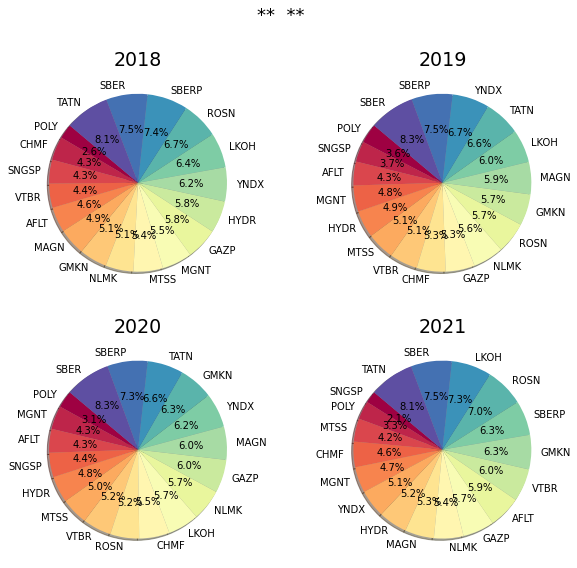

In [14]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
plot_weights_pie(weights_year.iloc[:, :-1].T.values, assets)

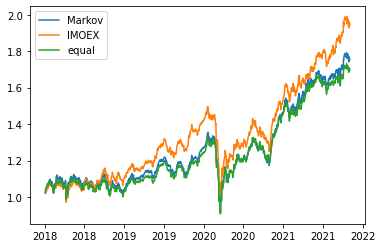

In [15]:
fig, ax = plt.subplots(1)

plt.plot(d['Markov'],label='Markov')
plt.plot(d['indics'],label='IMOEX')
plt.plot(d['Equal'],label='equal')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.legend()

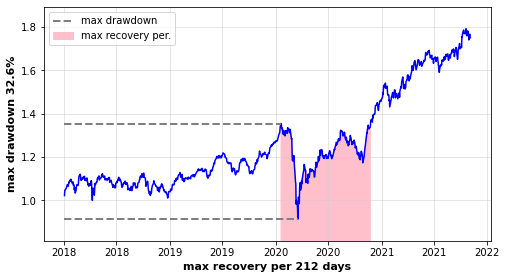

In [16]:
show_stats_of_stock(d['Markov'])

## Tobin

In [17]:
label = 'Tobin'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = TobinPortfolio, risk_det=risk_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

IMOEX       Equal      Markov       Tobin
mean_return      0.174250    0.143693    0.153080    0.139942
mean_risk        0.169998    0.156667    0.162872    0.169733
max_drawndown  -34.388432  -31.600236  -32.584651  -31.692730
max_recovery   224.000000  186.000000  212.000000  320.000000

In [18]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Treynor

In [19]:
label = 'Treynor'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = TreynorPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

IMOEX       Equal      Markov       Tobin     Treynor
mean_return      0.174250    0.143693    0.153080    0.139942    0.100299
mean_risk        0.169998    0.156667    0.162872    0.169733    0.188231
max_drawndown  -34.388432  -31.600236  -32.584651  -31.692730  -22.521304
max_recovery   224.000000  186.000000  212.000000  320.000000  517.000000

In [20]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Jensen

In [21]:
n = 16
x = np.ones(n)
np.eye(n) @ x < 0.3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [22]:
label = 'Jensen'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = JensenPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

IMOEX       Equal      Markov       Tobin     Treynor  \
mean_return      0.174250    0.143693    0.153080    0.139942    0.100299   
mean_risk        0.169998    0.156667    0.162872    0.169733    0.188231   
max_drawndown  -34.388432  -31.600236  -32.584651  -31.692730  -22.521304   
max_recovery   224.000000  186.000000  212.000000  320.000000  517.000000   

                   Jensen  
mean_return      0.108741  
mean_risk        0.183627  
max_drawndown  -29.444473  
max_recovery   518.000000

In [23]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Sharp

In [24]:
class SharpPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.ret_det = args['ret_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)
        ones_vec = np.ones(n)

        obj = cvx.Maximize(self.returns.T @ x - self.ret_det - cvx.matrix_frac(x, self.cov_mat))
        constraints = [np.ones(n).T @ x == 1,
                      np.eye(n) @ x <= 0.3]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [25]:
label = 'Sharp'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = SharpPortfolio, ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

IMOEX       Equal      Markov       Tobin     Treynor  \
mean_return      0.174250    0.143693    0.153080    0.139942    0.100299   
mean_risk        0.169998    0.156667    0.162872    0.169733    0.188231   
max_drawndown  -34.388432  -31.600236  -32.584651  -31.692730  -22.521304   
max_recovery   224.000000  186.000000  212.000000  320.000000  517.000000   

                   Jensen       Sharp  
mean_return      0.108741    0.150386  
mean_risk        0.183627    0.164204  
max_drawndown  -29.444473  -32.422214  
max_recovery   518.000000  281.000000

In [26]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

# General Results

In [27]:
df_res_final = df_res.T.reset_index()
df_res_final.sort_values(by = 'mean_return')

index  mean_return  mean_risk  max_drawndown  max_recovery
4  Treynor     0.100299   0.188231     -22.521304         517.0
5   Jensen     0.108741   0.183627     -29.444473         518.0
3    Tobin     0.139942   0.169733     -31.692730         320.0
1    Equal     0.143693   0.156667     -31.600236         186.0
6    Sharp     0.150386   0.164204     -32.422214         281.0
2   Markov     0.153080   0.162872     -32.584651         212.0
0    IMOEX     0.174250   0.169998     -34.388432         224.0

In [28]:
df_res_final.to_excel(f'df_res_final_{market}.xlsx', index=None)

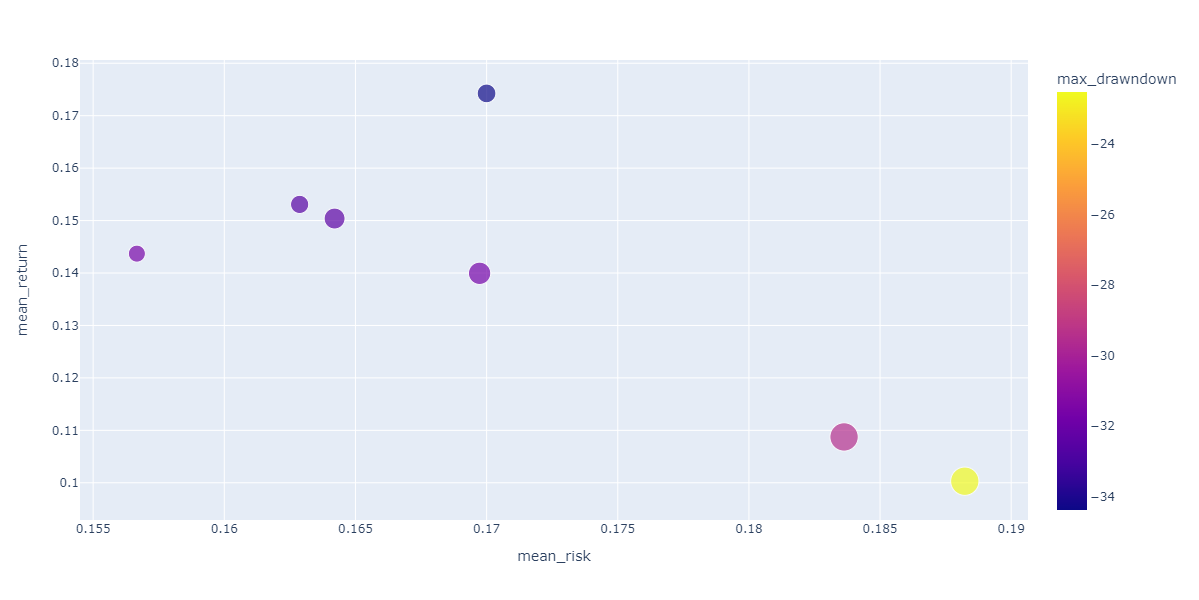

In [29]:
fig = px.scatter(df_res_final, x = 'mean_risk', y = 'mean_return', size='max_recovery',  color="max_drawndown", hover_name = 'index', width=800, height=600)
fig.show()

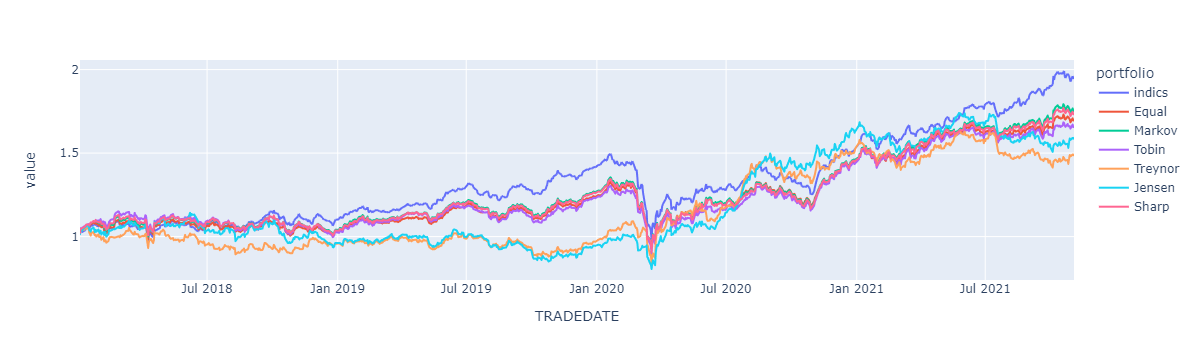

In [30]:
time_res = pd.DataFrame(d).reset_index()
filtr = ['indics', 'Equal', 'Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']
time_res_m = pd.melt(time_res, id_vars=['TRADEDATE'], var_name='portfolio')

time_res_m_filtered = time_res_m.query('portfolio in @filtr')
px.line(time_res_m_filtered, x="TRADEDATE", y="value", color='portfolio')

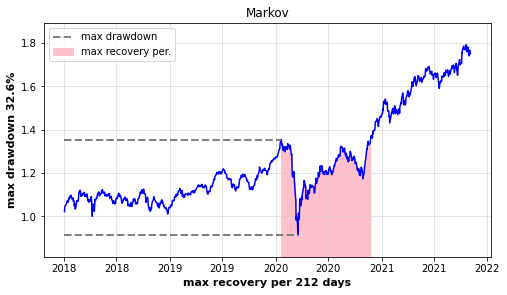

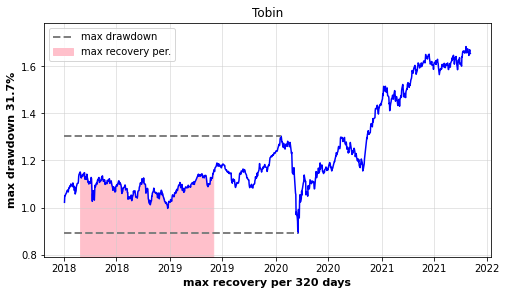

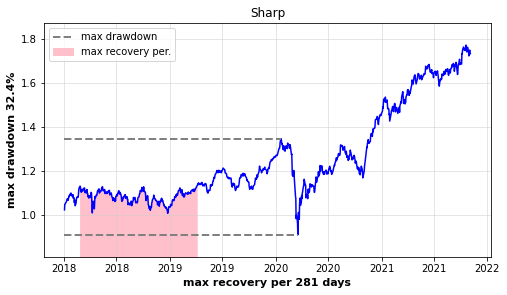

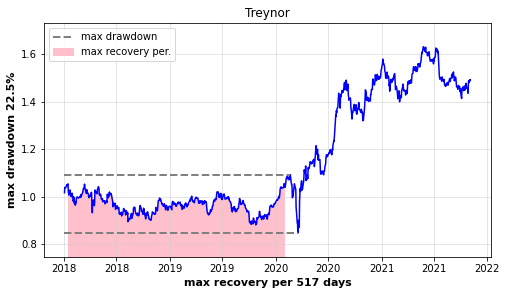

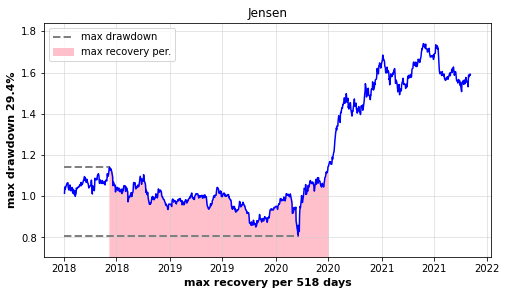

In [31]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    show_stats_of_stock(d[label], label)

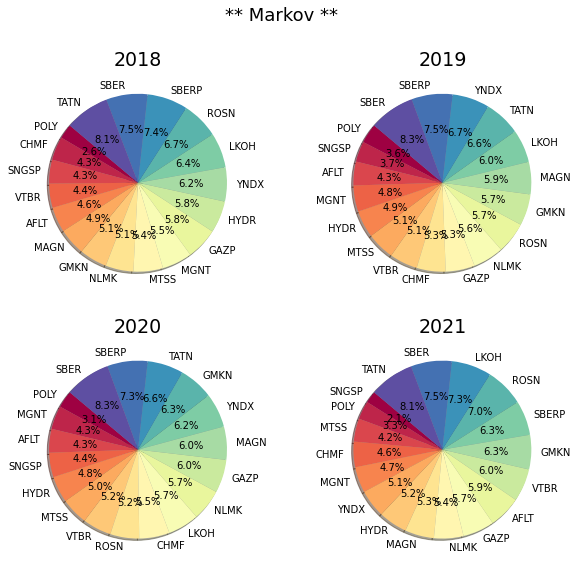

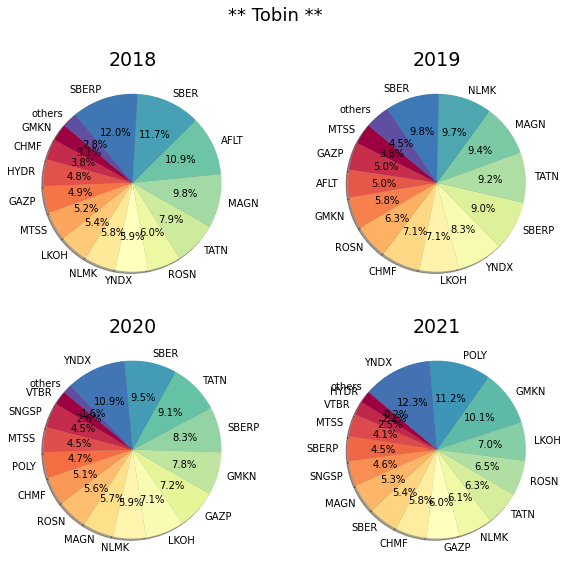

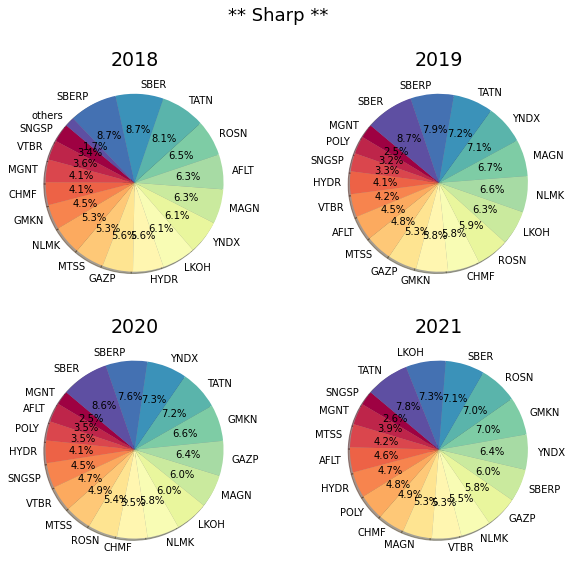

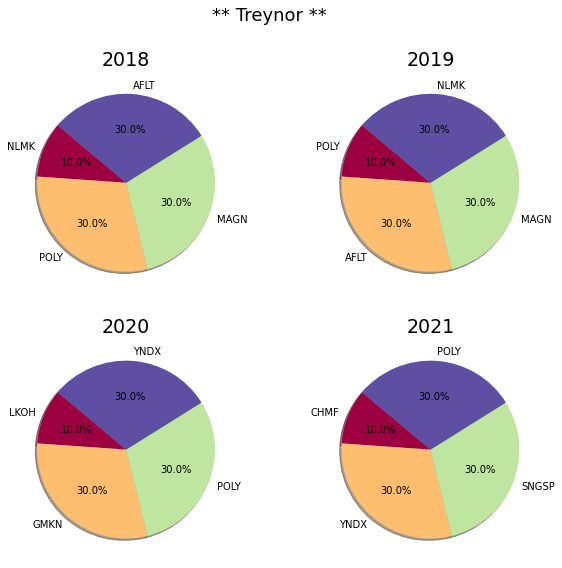

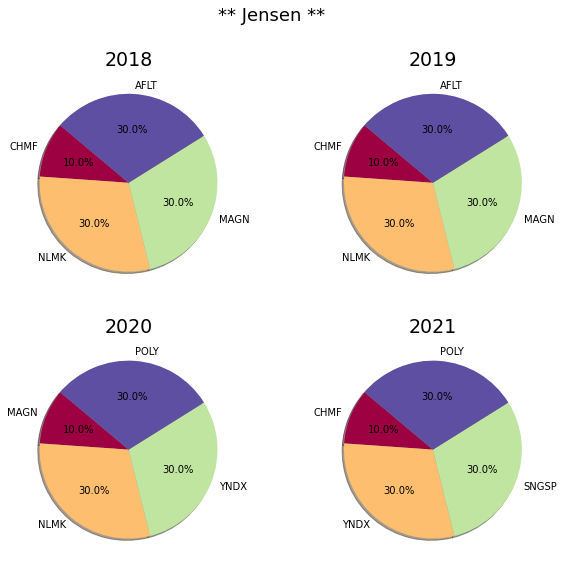

In [32]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
    plot_weights_pie(weights_year.iloc[:, :-1].T.values, assets, label)

In [33]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Treynor']
weights_year

2018          2019          2020          2021 portfolio
AFLT   2.999999e-01  3.000000e-01  1.529277e-07  3.286757e-08   Treynor
CHMF   5.865973e-07  3.648909e-08  2.376016e-07  9.999895e-02   Treynor
GAZP   2.863949e-08  7.367828e-09  5.315246e-07  1.053312e-07   Treynor
GMKN   5.439590e-08  9.264402e-09  2.999986e-01  2.105043e-07   Treynor
HYDR   5.231264e-08  7.446350e-09  1.152643e-07  8.989839e-08   Treynor
LKOH   3.239314e-08  2.273015e-08  9.999744e-02  5.381546e-08   Treynor
MAGN   2.999999e-01  3.000000e-01  4.718599e-07  1.766820e-07   Treynor
MGNT   2.794708e-08  1.030583e-08  6.915219e-08  6.807590e-08   Treynor
MTSS   8.039685e-08  8.178512e-09  4.818772e-07  1.741496e-07   Treynor
NLMK   9.999879e-02  3.000000e-01  4.908494e-07  2.259132e-07   Treynor
POLY   2.999998e-01  9.999983e-02  2.999997e-01  2.999999e-01   Treynor
ROSN   3.276713e-08  1.164885e-08  2.381833e-07  6.178087e-08   Treynor
SBER   9.506134e-08  7.517536e-09  2.133092e-07  4.301614e-08   Treynor
SBERP  2.999605e-07  1.345899e-08  6.308984e-07  6.515012e-08   Treynor
SNGSP  5.469503e-08  7.896313e-09  4.876317e-07  2.999999e-01   Treynor
TATN   3.134674e-08  3.982645e-08  3.847530e-07  3.497982e-08   Treynor
VTBR   3.250422e-08  9.513519e-09  1.082395e-07  4.298438e-08   Treynor
YNDX   9.543415e-08  1.465405e-08  2.999997e-01  2.999999e-01   Treynor

In [34]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Jensen']
weights_year

2018          2019          2020          2021 portfolio
AFLT   3.000000e-01  3.000000e-01  1.857486e-09  5.140960e-10    Jensen
CHMF   9.999998e-02  1.000000e-01  9.924376e-09  9.999999e-02    Jensen
GAZP   3.074073e-09  1.016783e-10  4.876949e-09  8.705068e-10    Jensen
GMKN   2.988618e-09  1.030261e-10  1.525017e-08  9.457803e-10    Jensen
HYDR   2.970179e-09  4.619142e-11  2.136548e-09  9.262827e-10    Jensen
LKOH   2.132401e-09  4.580566e-11  7.024287e-09  5.801813e-10    Jensen
MAGN   3.000000e-01  3.000000e-01  9.999739e-02  1.461547e-09    Jensen
MGNT   2.300550e-09  2.003933e-11  9.479649e-10  6.816402e-10    Jensen
MTSS   3.613470e-09  1.021212e-10  3.195887e-06  1.193990e-09    Jensen
NLMK   3.000000e-01  3.000000e-01  2.999993e-01  1.740631e-09    Jensen
POLY   3.119939e-08  1.027086e-10  3.000000e-01  3.000000e-01    Jensen
ROSN   2.095239e-09  7.989542e-11  1.909837e-08  7.122000e-10    Jensen
SBER   8.999801e-10  2.387006e-11  3.359568e-09  8.930535e-10    Jensen
SBERP  1.000708e-09  2.936516e-11  3.780562e-09  9.708458e-10    Jensen
SNGSP  2.171196e-09  5.276137e-11  3.785114e-08  3.000000e-01    Jensen
TATN   1.291357e-09  3.765212e-11  5.446418e-09  1.171314e-09    Jensen
VTBR   1.824566e-09  4.786970e-11  3.784169e-09  8.263976e-10    Jensen
YNDX   3.801965e-09  1.021989e-10  3.000000e-01  3.000000e-01    Jensen